# Tungsten Carbide Inverse

In [1]:
import os, openai
#key

In [2]:
lab_pool = set()
with open("paper/data/Tungsten carbide data update.csv") as f:
    with open("paper/data/co_train.csv", "w") as g:
        g.write('conditions,coyield\n')
        for line in f.readlines():
            if len(line) < 5:
                continue
            x = line[1:].split(",")[0]
            y = line.split("of")[1][:-4]
            g.write(f'"{x}",{y}\n')
            lab_pool.add(x)

In [3]:
from itertools import product

wtr = range(4, 30)
ctempr = range(600, 1000 + 50, 50)
tempr = range(250, 350 + 25, 25)
dpwt = ["0.5 wt%", "5 wt%"]
dpotanti = [
    "with Co dopant metal",
    "with Fe dopant metal",
    "with Cu dopant metal",
    "with Pt dopant metal",
    "with Ni dopant metal",
]
dopantr = ["without any dopant metal"]
for w, d in product(dpwt, dpotanti):
    dopantr.append(f"{d} at {w}")

with open("paper/data/co_pool.txt", "w") as f:
    for wt, ctemp, temp, dopant in product(wtr, ctempr, tempr, dopantr):
        prompt = (
            f"A {wt} wt% tungsten carbide catalyst was prepared {dopant} and carburized at {ctemp} °C. "
            f"The reaction was run at {temp} °C"
        )
        if prompt in lab_pool:
            print("skipping found one")
            continue
        f.write(prompt.split(",")[0] + "\n")

skipping found one
skipping found one
skipping found one
skipping found one


# Mult Prediction

In [4]:
import bolift
import numpy as np
import matplotlib.pyplot as plt
import json
import pandas as pd
from langchain.prompts.prompt import PromptTemplate


data_path = "paper/data/co_train.csv"
np.random.seed(0)

/opt/homebrew/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
raw_data = pd.read_csv(data_path)
raw_data

,conditions,coyield
0,A 15 wt% tungsten carbide catalyst was prepare...,1.66
1,A 15 wt% tungsten carbide catalyst was prepare...,3.03
2,A 15 wt% tungsten carbide catalyst was prepare...,1.61
3,A 15 wt% tungsten carbide catalyst was prepare...,4.12
4,A 15 wt% tungsten carbide catalyst was prepare...,0.52
5,A 15 wt% tungsten carbide catalyst was prepare...,3.36
6,A 15 wt% tungsten carbide catalyst was prepare...,9.80
7,A 15 wt% tungsten carbide catalyst was prepare...,18.98
8,A 15 wt% tungsten carbide catalyst was prepare...,6.21
9,A 15 wt% tungsten carbide catalyst was prepare...,16.35


In [6]:
r = raw_data[raw_data.coyield == raw_data.coyield.max()]
print(r)
print(r.conditions.values)

                                          conditions  coyield
7  A 15 wt% tungsten carbide catalyst was prepare...    18.98
['A 15 wt% tungsten carbide catalyst was prepared with Cu dopant metal at 5 wt% and carburized at 835 °C. The reaction was run at 350 °C']


In [7]:
asktell = bolift.AskTellFewShotTopk(
    x_formatter=lambda x: f'the synthesis procedure:"{x}"',
    y_name="the CO yield",
    y_formatter=lambda y: f"{y:.2f}%",
    model="gpt-4",
    # model="text-davinci-003",
    temperature=1,
    selector_k=5,
)

In [8]:
for i, (c, y) in raw_data.iterrows():
    if i < len(raw_data) - 1:
        asktell.tell(c, y)

In [9]:
asktell.predict(c), y

(DiscreteDist([ 8.91  9.65  9.58  8.93 11.29], [0.2 0.2 0.2 0.2 0.2]), 10.89)

In [10]:
# tell the last one
asktell.tell(c, y)

In [15]:
s = asktell.inv_predict(20)
s

'the synthesis procedure:"A 30 wt% tungsten carbide catalyst was prepared with Cu dopant metal at 5 wt% and carburized at 835 °C. The reaction was run at 350 °C"'

In [17]:
yhats=[]
stds=[]

for _ in range(50):
  inv_dist = asktell.predict(s)
  yhats.append(inv_dist.mean())
  stds.append(inv_dist.std())
  # print(inv_dist, inv_dist.mean(), inv_dist.std())

Retrying langchain.chat_models.openai.ChatOpenAI.completion_with_retry.<locals>._completion_with_retry in 4.0 seconds as it raised RateLimitError: That model is currently overloaded with other requests. You can retry your request, or contact us through our help center at help.openai.com if the error persists. (Please include the request ID 2e5ebb44c86b547d147c2d619f5c30da in your message.).


<Axes: ylabel='Count'>

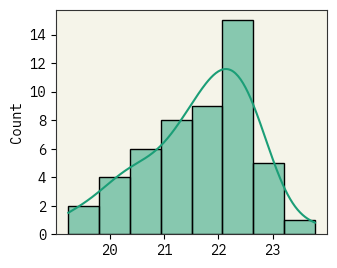

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt
import urllib.request
import matplotlib.font_manager as font_manager
urllib.request.urlretrieve('https://github.com/google/fonts/raw/main/ofl/ibmplexmono/IBMPlexMono-Regular.ttf', 'IBMPlexMono-Regular.ttf')
fe = font_manager.FontEntry(
    fname='IBMPlexMono-Regular.ttf',
    name='plexmono')
font_manager.fontManager.ttflist.append(fe)
plt.rcParams.update({'axes.facecolor':'#f5f4e9',
            'grid.color' : '#AAAAAA',
            'axes.edgecolor':'#333333',
            'figure.facecolor':'#FFFFFF',
            'axes.grid': False,
            'axes.prop_cycle':   plt.cycler('color', plt.cm.Dark2.colors),
            'font.family': fe.name,
            'figure.figsize': (3.5,3.5 / 1.2),
            'ytick.left': True,
            'xtick.bottom': True
           })

sns.histplot(yhats, kde=True)

In [7]:
with open("paper/data/co_pool.txt") as f:
    pool = bolift.Pool(list(f.readlines()))
print(len(pool))

12866


In [55]:
result = asktell.ask(pool, "greedy", inv_filter=50)

In [56]:
x = result[0][0]
print(x)

A 23 wt% tungsten carbide catalyst was prepared with Pt dopant metal at 5 wt% and carburized at 950 °C. The reaction was run at 300 °C



In [57]:
dist = asktell.predict(x)
print(dist, dist.mean(), dist.std())

DiscreteDist([ 8.76  8.15  8.12 10.58  9.14], [0.22358422 0.22371829 0.22313449 0.15054542 0.17901758]) 8.822745105043543 0.833799309165339


# GPR

In [ ]:
asktell = bolift.AskTellGPR(
    x_formatter=lambda x: f'synthesis procedure:"{x}"',
    y_name="CO yield",
    y_formatter=lambda y: f"{y:.2f}",
)

In [ ]:
for i, (c, y) in raw_data.iterrows():
    if i < len(raw_data) - 1:
        asktell.tell(c, y)

In [ ]:
asktell.predict(c), y

In [ ]:
# tell the last one
asktell.tell(c, y)

In [ ]:
with open("data/co_pool.txt") as f:
    pool = bolift.Pool(list(f.readlines()))

In [ ]:
result = asktell.ask(pool, "greedy")

In [ ]:
x = result[0][0]
print(x)

In [ ]:
dist = asktell.predict(x)
print(dist, dist.mean(), dist.std())